In [5]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import yaml
import datetime

with open('input.yaml', 'r') as f:
    try:
        args = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

plt.style.use('seaborn-poster')
matplotlib.rcParams['font.family'] = 'Liberation Sans'

plt.style.use('bmh')
font = {'family' : 'FreeSans',
        'size'   : 14}
matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=3)


def human_time(seconds):
    days = seconds // 86400
    hours = seconds // 3600 % 24
    minutes = seconds // 60 % 60
    seconds = seconds % 60
    return f'{days:.0f} days, {hours:.0f} hours, {minutes:.0f} minutes, {seconds:.0f} seconds'

def used(name, epoch, data):

    if name == 'val_loss': string = 'Validation'
    if name in ('train_loss', 'loss_1'): string = 'Training'

    # Minus 1 because models are saved with one extra epoch
    values = (epoch, data[name][data['epoch'] == epoch].values[0])
    print(f'Epoch used      -> {values[0]}')
    print(f'{string} loss -> {values[1]}')
    return values


def plot_training(data, point_used=False, plot_args=False):

    data['train_loss'] = data['train_loss'].where(data['train_loss'] < 1e6, None)
    data = data.interpolate(method='linear')
    
    levels = data['level'].unique()
    lvl_range = [(data[data['level'] == lvl]['epoch'].min(), data[data['level'] == lvl]['epoch'].max()) for lvl in levels]
    cmap = matplotlib.cm.get_cmap('gist_rainbow')
    cmap_colors = cmap(np.linspace(0, 1, len(levels)))

    fig, ax = plt.subplots()
    minimums = {}
    for level in levels:

        data[data['level'] == level].plot(x='epoch', y=plot_args['parameters'],
                                          figsize=(8,5), ax=ax)
        colors = [line.get_color() for line in ax.get_lines()]

        for color, param in zip(colors, plot_args['parameters']):
            min_x, min_y = data["epoch"].iloc[data[param].argmin()], data[param].min()
            ax.scatter([min_x], [min_y], c=color, marker='*', s=400)
            minimums[param] = min_x, min_y
        
        
        if plot_args['show_levels']: ax.axvspan(*lvl_range[level], alpha=0.2, label=f'level {level}', color=cmap_colors[level])
        
        plt.gca().set_prop_cycle(None)
    
    if plot_args['show_thresh']: ax.axhline(args['thresh_lvlup'], ls='--', color='gray', lw=2)
        
    if point_used is not None and point_used['epoch'] != 0:
        points_used = used(point_used['parameter'], point_used['epoch'], data)
        ax.scatter(*points_used, c='black', marker='x', s=100, zorder=2.5, label='used')

    if plot_args is not False:
        ax.set_title(plot_args['title'])
        if plot_args['show_legend']: ax.legend(plot_args['legend_handles'], loc='upper right')
        ax.set_ylim(plot_args['ylim']) if plot_args['set_ylim'] else ax.set_ylim(bottom=0)
        if plot_args['set_xlim']:  ax.set_xlim(plot_args['xlim'])

    return minimums, fig, ax


Epoch used      -> 145
Training loss -> 0.7262369784744785
Minimum train_loss at epoch 42 with value 0.8559.
Minimum var_loss at epoch 1 with value 0.0245.
Minimum loss_1 at epoch 57 with value 0.6312.
Current running time is 1 days, 1 hours, 6 minutes, 45 seconds.


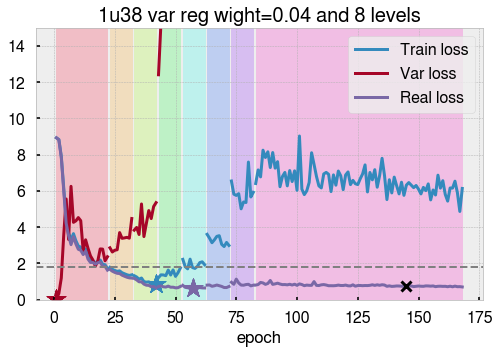

In [6]:
data = pd.read_csv('log/monitor.csv')

plot_args = {
    'title': '1u38 var reg wight=0.04 and 8 levels',
    'parameters': ['train_loss',  'var_loss', 'loss_1'], 
    'show_legend': True, 'legend_handles': ('Train loss', 'Var loss', 'Real loss'),
    'set_ylim': True, 'ylim': (0,15),
    'set_xlim': False, 'xlim': (0, 50),
    'show_levels': True, 'show_thresh': True,
}

# Indicate level used on test
point_used = {'parameter': 'loss_1',
              'epoch'    : 0}

minimums, fig, ax = plot_training(data, point_used, plot_args)

for key, val in minimums.items():
    print(f'Minimum {key} at epoch {val[0]} with value {val[1]:.4f}.')

print(f'Current running time is {human_time(data["t"].iloc[-1])}.')